In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

#%pip install keras-tcn --no-dependencies

#%pip install tensorflow-addons[tensorflow-gpu] --no-dependencies

#%pip install pandas --upgrade

#%pip install import multivariate_cwru


tf.config.list_physical_devices(device_type=None)
physical_devices = tf.config.list_physical_devices('GPU')
visible_devices = tf.config.get_visible_devices()
print(visible_devices)
num_GPU = len(tf.config.experimental.list_physical_devices('/physical_device:GPU:0'))
#if num_GPU == 1:
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#elif num_GPU == 2:
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#elif num_GPU == 4:
    #tf.config.experimental.set_memory_growth(physical_devices[1], True)
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #tf.config.experimental.set_memory_growth(physical_devices[1], True)
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)
#print("Num GPUs Available: ", num_GPU)
#tf.debugging.set_log_device_placement(False)
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1"])
#strategy = tf.distribute.MirroredStrategy(
    #cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
# Data science libraries
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

#Deep Learning pkgs
from tensorflow.keras import backend as K, Input, Model, optimizers
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.metrics
from tensorflow.keras.metrics import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.activations import swish
K.backend()

# Python
from IPython.core.debugger import set_trace
from pathlib import Path
import os
import datetime
import time
import glob
from timeit import default_timer as timer


#Project Specific
import tcn_ed
from tcn_ed import TCN, tcn_full_summary, compiled_tcn
import help_matt_val
from help_matt_val import predict_batch, create_predict_frames#, create_data_batch, create_frames, sig_divide, matfile_to_df,  create_data_batch_notest, create_frames_notest
from help_pre import create_data_batcht as Create_Batch, create_pred_batch
import multivariate_cwru

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
os.getcwd()

'/home/ubuntu/upload_dir'

In [4]:
working_dir = Path('.')
DATA1_PATH = Path("./Datasets")
DATA_PATH = Path("./Datasets/CWRU")
save_model_path = working_dir / 'Model' 
DE_path = DATA_PATH / '12DriveEndFault'
DE_path1 = DE_path / '1730'
DE_path2 = DE_path / '1750'
DE_path3 = DE_path / '1772'
DE_path4 = DE_path / '1797'

FE_path = DATA_PATH / '12FanEndFault'
FE_path1 = FE_path / '1730'
FE_path2 = FE_path / '1750'
FE_path3 = FE_path / '1772'
FE_path4 = FE_path / '1797'

DE48_path = DATA_PATH / '48DriveEndFault'
DE48_path1 = DE48_path / '1730'
DE48_path2 = DE48_path / '1750'
DE48_path3 = DE48_path / '1772'
DE48_path4 = DE48_path / '1797'

Normal_path = DATA_PATH / 'NormalBaseline'
Normal_path1 = Normal_path / '1730'
Normal_path2 = Normal_path / '1750'
Normal_path3 = Normal_path / '1772'
Normal_path4 = Normal_path / '1797'

Paths = [DE_path1, DE_path2, DE_path3, DE_path4, FE_path1, FE_path2, FE_path3, FE_path4, DE48_path1, DE48_path2,  DE48_path4, Normal_path1, Normal_path2, Normal_path3, Normal_path4]
data_path = Paths

val_path = DATA1_PATH / 'for_pred'
Val_path= [val_path]



segment_length = 2400 # The length of the window used to take sub-arrays from each file
step_size = 300 # the amount the window moves along the sub-array
split_perc = 0.2 # percentage of data to put towards the test set
b_size = 1024
b_size1 = int(b_size*2)
#b_size2 = int(b_size / 4)

#step_length = step_size

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)
        
data_path = Paths

```'N':0, 'B':1, 'IR':2, 'OR':3```


In [6]:
with mirrored_strategy.scope():
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.3,   
                                  patience=40, 
                                  min_lr=0.000000015,
                                  verbose=1, 
                                  cooldown=5)

    ES_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             min_delta=0.00001, 
                                             patience=70, 
                                             verbose=1, 
                                             mode='auto', 
                                             baseline=None, 
                                             restore_best_weights=True)



    callback = [reduce_lr, ES_cb]

def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations
        
def pred_accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            # convert dense predictions to labels
            y_pred_labels = K.cast(y_pred, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def create_model(num_feat,
                 num_classes,
                 filt_num,
                 kernel_num,
                 stack, dilation,
                 lr,
                 drop_rate,
                 segment_length,
                 use_skip,
                 opt):

    with mirrored_strategy.scope():

        input_layer = Input(shape=(segment_length, num_feat))

        def get_opt():
            if opt == 'adam':
                return optimizers.Adam(lr=lr)
            elif opt == 'rmsprop':
                return optimizers.RMSprop(lr=lr)
            else:
                raise Exception('Only Adam and RMSProp are available here')
            
        x = TCN(nb_filters=filt_num,
                kernel_size=kernel_num,
                nb_stacks=stack,
                dilations=[2 ** i for i in range(dilation)],
                padding='causal',
                use_skip_connections=use_skip,
                dropout_rate=drop_rate,
                return_sequences=False,
                activation='swish', 
                kernel_initializer='he_uniform',
                use_batch_norm=True,
                use_layer_norm=False,
                use_weight_norm=False,
                name='Model')(input_layer)

        tcn = TCN(nb_filters=filt_num,
                  kernel_size=kernel_num,
                  nb_stacks=stack,
                  dilations=[2 ** i for i in range(dilation)],
                  padding='causal',
                  use_skip_connections=use_skip,
                  dropout_rate=drop_rate,
                  return_sequences=False,
                  activation='swish', 
                  kernel_initializer='he_uniform',
                  use_batch_norm=True,
                  use_layer_norm=False,
                  use_weight_norm=False,
                  name='Model')

        print('Receptive Field Size: %s' % tcn.receptive_field)



        print('x.shape=', x.shape)


        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax', dtype='float32')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.

    with mirrored_strategy.scope():
        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

        print('model.x = {}'.format(input_layer.shape))
        print('model.y = {}'.format(output_layer.shape))

        print('Filter Length: %s' % filt_num)
        print('Kernel Size: %s' % kernel_num)
        print('Dilation: %s' % dilation)
        print('Learning Rate: %s' % lr)
        print('Dropout Rate: %s' % drop_rate)

        model.summary()


        return model

def train_func(train_data,
               test_dataset,
               Val_dataset,
               predict_labels,
               segment_length,
               runs,
               filt_num,
               kernel_num,
               dilation,
               stack,
               learn_r,
               drop_rate,
               Model_num):
    
    
        
    time1 = timer()
        
    working_dir = Path('.')
    model_path = working_dir / 'Model' / ('Model_{}_k{}_s{}_di{}_dr{}_L{}'.format(Model_num, kernel_num, stack, dilation, drop_rate, segment_length))
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.3,   
                                  patience=40, 
                                  min_lr=0.000015,
                                  verbose=0, 
                                  cooldown=5)

    ES_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             min_delta=0.00001, 
                                             patience=70, 
                                             verbose=0, 
                                             mode='auto', 
                                             baseline=None, 
                                             restore_best_weights=True)
    

    # to load best weights model.load_weights(latest)

    callback = ES_cb# ] [reduce_lr, 
    #seg_length = None
    time_out = timer()-time1
    print('Time till start of create model %s' % time_out)
    time2 = timer()
    model = create_model(num_feat=1,
                         num_classes=4,
                         filt_num=filt_num,
                         kernel_num=kernel_num,
                         stack=stack,
                         dilation=dilation,
                         lr=learn_r,
                         drop_rate=drop_rate,
                         segment_length = segment_length,
                         use_skip=True,
                         opt='adam')

    time3 = timer()
    time_out = time3-time2
    print('Time to create model %s' % time_out)
    with mirrored_strategy.scope():
        history = model.fit(train_data,
                  epochs=runs,
                  verbose=2,
                  callbacks=callback,
                  validation_data=test_dataset)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.show()
    time_out = timer()-time3
    print('Time to fit model %s' % time_out)
    with mirrored_strategy.scope():
        y_preds = model.predict(Val_dataset,
                                       verbose=1,
                                       callbacks=callback,
                                      )
        y_argmax2 = np.argmax(y_preds,axis=1)
        predict_labels = np.squeeze(predict_labels[:], axis=1)
        #for pred1, pred2, pred3, pred4 in y_pred:
        #y_argmax = []
        #i=0
        perc_score = tf.dtypes.cast((sum(pred_accuracy(predict_labels, y_argmax2))/(len(predict_labels))), tf.float16)
        Accuracy_test = float(perc_score)
        print('Prediction Accuracy: %s' % Accuracy_test)
        con_mat = metrics.confusion_matrix(predict_labels, y_argmax2)
        class_report = metrics.classification_report(predict_labels, y_argmax2, digits=3)
        print(con_mat, '\n\n')
        print(class_report, '\n\n')
    
    

    
    d = {'segment length':[segment_length], 'filters': [filt_num], 'kernel size': [kernel_num], 'stacks':[stack], 'dropout': [drop_rate], 'lr': [learn_r], 'dilation': [dilation], 'Training Time': time_out, 'train loss': [history.history['loss'][-1]], 'train acc': [history.history['sparse_categorical_accuracy'][-1]], 'eval acc': [history.history['val_sparse_categorical_accuracy'][-1]], 'Eval Acc': [Accuracy_test],'C1 correct': [con_mat[0][0]], 'C1 as C2':[con_mat[0][1]], 'C1 as C3':[con_mat[0][2]], 'C1 as C4':[con_mat[0][3]],'C2 as C1': [con_mat[1][0]], 'C2 correct':[con_mat[1][1]], 'C2 as C3':[con_mat[1][2]], 'C2 as C4':[con_mat[1][3]],'C3 as C1': [con_mat[2][0]], 'C3 as C2':[con_mat[2][1]], 'C3 correct':[con_mat[2][2]], 'C3 as C4':[con_mat[2][3]],'C4 as C1': [con_mat[3][0]], 'C4 as C2':[con_mat[3][1]], 'C4 as C3':[con_mat[3][2]], 'C4 correct':[con_mat[3][3]]}
    
    
    append_list2_in = pd.DataFrame.from_dict(d)
    
    time_out = timer()-time1
    print('Total Time %s' % time_out)
    
    return history, y_preds, append_list2_in

def create_model2(num_feat,
                 num_classes,
                 filt_num,
                 kernel_num,
                 stack, dilation,
                 lr,
                 drop_rate,
                 segment_length,
                 use_skip,
                 opt):




    with mirrored_strategy.scope():
        #x =Sequential()

        
        input_layer = Input(shape=(segment_length, num_feat))

        def get_opt():
            if opt == 'adam':
                return optimizers.Adam(lr=lr)
            elif opt == 'rmsprop':
                return optimizers.RMSprop(lr=lr)
            else:
                raise Exception('Only Adam and RMSProp are available here')
            
        x = TCN(nb_filters=filt_num,
                kernel_size=kernel_num,
                nb_stacks=stack,
                dilations=[2 ** i for i in range(dilation)],
                padding='causal',
                use_skip_connections=use_skip,
                dropout_rate=drop_rate,
                return_sequences=False,
                activation='swish', 
                kernel_initializer='he_uniform',
                use_batch_norm=True,
                use_layer_norm=False,
                use_weight_norm=False,
                name='Model')(input_layer)

        tcn = TCN(nb_filters=filt_num,
                  kernel_size=kernel_num,
                  nb_stacks=stack,
                  dilations=[2 ** i for i in range(dilation)],
                  padding='causal',
                  use_skip_connections=use_skip,
                  dropout_rate=drop_rate,
                  return_sequences=False,
                  activation='swish', 
                  kernel_initializer='he_uniform',
                  use_batch_norm=True,
                  use_layer_norm=False,
                  use_weight_norm=False,
                  name='Model')

        print('Receptive Field Size: %s' % tcn.receptive_field)



        print('x.shape=', x.shape)


        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax', dtype='float32')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.

    with mirrored_strategy.scope():
        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

        print('model.x = {}'.format(input_layer.shape))
        print('model.y = {}'.format(output_layer.shape))

        print('Filter Length: %s' % filt_num)
        print('Kernel Size: %s' % kernel_num)
        print('Dilation: %s' % dilation)
        print('Learning Rate: %s' % lr)
        print('Dropout Rate: %s' % drop_rate)

        model.summary()


        return model

def train_func2(train_data,
               test_dataset,
               Val_dataset,
               predict_labels,
               segment_length,
               runs,
               filt_num,
               kernel_num,
               dilation,
               stack,
               learn_r,
               drop_rate,
               Model_num):
    
    
        
    time1 = timer()
        
    working_dir = Path('.')
    model_path = working_dir / 'Model' / ('Model_{}_k{}_s{}_di{}_dr{}_L{}.H5'.format(Model_num, kernel_num, stack, dilation, drop_rate, segment_length))
    
    

    #seg_length = None
    time_out = timer()-time1
    print('Time till start of create model %s' % time_out)
    time2 = timer()
    model = create_model(num_feat=1,
                         num_classes=4,
                         filt_num=filt_num,
                         kernel_num=kernel_num,
                         stack=stack,
                         dilation=dilation,
                         lr=learn_r,
                         drop_rate=drop_rate,
                         segment_length = segment_length,
                         use_skip=True,
                         opt='adam')

    time3 = timer()
    time_out = time3-time2
    print('Time to create model %s' % time_out)
    with mirrored_strategy.scope():
        history = model.fit(train_data,
                  epochs=runs,
                  verbose=2,
                  callbacks=callback,
                  validation_data=test_dataset)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.show()
    time_out = timer()-time3
    print('Time to fit model %s' % time_out)
    with mirrored_strategy.scope():
        y_preds = model.predict(Val_dataset,
                                       verbose=0,
                                       callbacks=callback,
                                      )
        y_argmax2 = np.argmax(y_preds,axis=1)
        predict_labels = np.squeeze(predict_labels[:], axis=1)
        #for pred1, pred2, pred3, pred4 in y_pred:
        #y_argmax = []
        #i=0
        perc_score = tf.dtypes.cast((sum(pred_accuracy(predict_labels, y_argmax2))/(len(predict_labels))), tf.float16)
        Accuracy_test = float(perc_score)
        print('Prediction Accuracy: %s' % Accuracy_test)
        con_mat = metrics.confusion_matrix(predict_labels, y_argmax2)
        class_report = metrics.classification_report(predict_labels, y_argmax2, digits=3)
        print(con_mat, '\n\n')
        print(class_report, '\n\n')
    
    

    
    d = {'segment length':[segment_length], 'filters': [filt_num], 'kernel size': [kernel_num], 'stacks':[stack], 'dropout': [drop_rate], 'lr': [learn_r], 'dilation': [dilation], 'Training Time': time_out, 'train loss': [history.history['loss'][-1]], 'train acc': [history.history['sparse_categorical_accuracy'][-1]], 'eval acc': [history.history['val_sparse_categorical_accuracy'][-1]], 'Eval Acc': [Accuracy_test],'C1 correct': [con_mat[0][0]], 'C1 as C2':[con_mat[0][1]], 'C1 as C3':[con_mat[0][2]], 'C1 as C4':[con_mat[0][3]],'C2 as C1': [con_mat[1][0]], 'C2 correct':[con_mat[1][1]], 'C2 as C3':[con_mat[1][2]], 'C2 as C4':[con_mat[1][3]],'C3 as C1': [con_mat[2][0]], 'C3 as C2':[con_mat[2][1]], 'C3 correct':[con_mat[2][2]], 'C3 as C4':[con_mat[2][3]],'C4 as C1': [con_mat[3][0]], 'C4 as C2':[con_mat[3][1]], 'C4 as C3':[con_mat[3][2]], 'C4 correct':[con_mat[3][3]]}
    
    
    append_list2_in = pd.DataFrame.from_dict(d)
       
    time_out = timer()-time1
    print('Total Time %s' % time_out)
    
    return model, history, y_preds, append_list2_in

In [ ]:
b_size = 256 #normally 2048 but 512 on colab
b_size2 = int(b_size / 4)
step_size = 300
step_length=step_size
segment_length = 2400
with mirrored_strategy.scope():
    train_dataset, test_dataset, y_s1 = Create_Batch(data_path, split_perc, segment_length, step_length, b_size)
waste_split = 0.1


In [ ]:
with mirrored_strategy.scope():
    val_dataset, X_v1, predict_labels= create_pred_batch(Val_path=Val_path, segment_length=segment_length, step_length=step_size, b_size=int(b_size/4))

# Batch Norm

In [ ]:
append_list_time1.sort_values(by=['segment length', 'kernel size', 'stacks', 'dilation', 'filters'], ascending=[True, False, False, False, True])
append_list_time1.to_csv(r'{}.csv'.format('List_Check_300'), index = False, header=['segment length', 'filters', 'kernel size', 'stacks', 'dropout', 'lr', 'dilation','Training Time', 'train loss', 'train acc', 'eval acc','Eval Acc','C1 correct', 'C1 as C2', 'C1 as C3', 'C1 as C4','C2 as C1', 'C2 correct', 'C2 as C3', 'C2 as C4','C3 as C1', 'C3 as C2', 'C3 correct', 'C3 as C4','C4 as C1', 'C4 as C2', 'C4 as C3', 'C4 correct'])

In [ ]:
append_list_time1

# Save and Reload Model

Sig Divide Time: 1.4923975467681885
Sig Divide Time: 8.276552438735962
Sig Divide Time: 1.1134204864501953
Model Number 1
Time till start of create model 7.225000081234612e-05
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

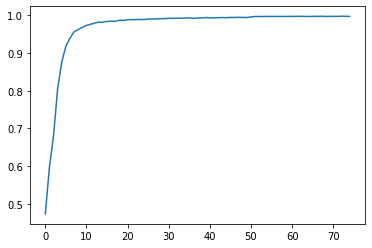

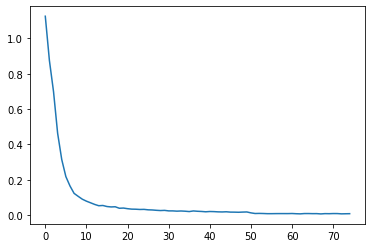

Time to fit model 4061.794782899
Prediction Accuracy: 0.60791015625
[[3218    0    0    0]
 [ 121 2676  173 1060]
 [   0 1616 2832    0]
 [   0 3116 1028 2312]] 


              precision    recall  f1-score   support

           0      0.964     1.000     0.982      3218
           1      0.361     0.664     0.468      4030
           2      0.702     0.637     0.668      4448
           3      0.686     0.358     0.470      6456

    accuracy                          0.608     18152
   macro avg      0.678     0.665     0.647     18152
weighted avg      0.667     0.608     0.609     18152
 


Total Time 4069.883972918


ValueError: too many values to unpack (expected 3)

In [10]:
tf.keras.backend.clear_session()
b_size = 2048 #normally 2048 but 512 on colab
b_size2 = int(b_size / 4)
step_size = 300
step_length=step_size
segment_length = 2400
with mirrored_strategy.scope():
    train_dataset, test_dataset, y_s1 = Create_Batch(data_path, split_perc, segment_length, step_length, b_size)
    val_dataset, X_v1, predict_labels= create_pred_batch(Val_path=Val_path, segment_length=segment_length, step_length=step_size, b_size=int(b_size/4))
waste_split = 0.1
append_list_time1 = pd.DataFrame
with mirrored_strategy.scope():
    
    #Tuned Param dropout
    Learning_Rate = 0.0125
    Drop_rate = 0.175
    Repeats = 75

    m_count = 1
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)
    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    Learning_Rate = 0.0125
    Drop_rate = 0.3
    Repeats = 75

    m_count = 2
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)

    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    tf.keras.backend.clear_session()
               

In [ ]:
tf.keras.backend.clear_session()
b_size = 1024 #normally 2048 but 512 on colab
b_size2 = int(b_size / 4)
step_size = 300
step_length=step_size
segment_length = 2400
with mirrored_strategy.scope():
    train_dataset, test_dataset, y_s1 = Create_Batch(data_path, split_perc, segment_length, step_length, b_size)
waste_split = 0.1
with mirrored_strategy.scope():
    
    #Tuned Param dropout
    Learning_Rate = 0.0125
    Drop_rate = 0.175
    Repeats = 75

    m_count = 1
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)
    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    Learning_Rate = 0.0125
    Drop_rate = 0.3
    Repeats = 75

    m_count = 2
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)

    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    tf.keras.backend.clear_session()
               

In [ ]:
tf.keras.backend.clear_session()
b_size = 512 #normally 2048 but 512 on colab
b_size2 = int(b_size / 4)
step_size = 300
step_length=step_size
segment_length = 2400
with mirrored_strategy.scope():
    train_dataset, test_dataset, y_s1 = Create_Batch(data_path, split_perc, segment_length, step_length, b_size)
    val_dataset, X_v1, predict_labels= create_pred_batch(Val_path=Val_path, segment_length=segment_length, step_length=step_size, b_size=int(b_size/4))
waste_split = 0.1
with mirrored_strategy.scope():
    
    #Tuned Param dropout
    Learning_Rate = 0.0125
    Drop_rate = 0.175
    Repeats = 75

    m_count = 1
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)
    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    Learning_Rate = 0.0125
    Drop_rate = 0.3
    Repeats = 75

    m_count = 2
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)

    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    tf.keras.backend.clear_session()
               

In [ ]:
tf.keras.backend.clear_session()
b_size = 256 #normally 2048 but 512 on colab
b_size2 = int(b_size / 4)
step_size = 300
step_length=step_size
segment_length = 2400
with mirrored_strategy.scope():
    train_dataset, test_dataset, y_s1 = Create_Batch(data_path, split_perc, segment_length, step_length, b_size)
    val_dataset, X_v1, predict_labels= create_pred_batch(Val_path=Val_path, segment_length=segment_length, step_length=step_size, b_size=int(b_size/4))
waste_split = 0.1
with mirrored_strategy.scope():
    
    #Tuned Param dropout
    Learning_Rate = 0.0125
    Drop_rate = 0.175
    Repeats = 75

    m_count = 1
    append_list_time1 = pd.DataFrame
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)
    
    Learning_Rate = 0.0125
    Drop_rate = 0.3
    Repeats = 75
    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    m_count = 2
    append_list_time1 = pd.DataFrame
    print('Model Number %s' % m_count)
    history, y_preds, res_list = train_func2(train_data=train_dataset,
                                            test_dataset=test_dataset,
                                            Val_dataset=val_dataset,
                                            predict_labels=predict_labels, 
                                            filt_num=16,
                                            kernel_num=11,
                                            dilation=7,
                                            stack=1,
                                            learn_r=Learning_Rate,
                                            drop_rate=Drop_rate,
                                            runs=Repeats,
                                            Model_num = m_count, 
                                            segment_length = segment_length)

    append_list_time1 = append_list_time1.append(res_list, ignore_index=True)
    tf.keras.backend.clear_session()
               